<a href="https://colab.research.google.com/github/naimish75/GIS/blob/main/ps4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uncovering Philadelphia’s Socioeconomic Landscape

Philadelphia is a city of vibrant neighborhoods, each with unique characteristics and challenges. This analysis dives deep into the city’s socioeconomic landscape to understand which neighborhoods are thriving, which are underdeveloped, and where there may be opportunities for growth.

Installing the necessary dependencies

In [19]:
!pip install geopandas==1.0.1
!pip install mapclassify
!pip install openpyxl
!pip install folium
!pip install contextily
!pip install holoviews geoviews bokeh cartopy
!pip install datashader
!pip install jupyter_bokeh

Importing the necessary libraries

In [20]:
import os, zipfile #basics
import pandas as pd #data management
import matplotlib.pyplot as plt #vis

import mapclassify #need for thematic map classification
import geopandas as gpd #gis/maps

#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import files #to download from colab onto hd

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )
from shapely.geometry import Point
import seaborn as sns
import contextily as ctx
import numpy as np

import matplotlib.patches as mpatches
import plotly.graph_objects as go
import plotly.express as px
import folium

Shapefile - Philadelphia County!!

In [21]:
! wget -q -O Philly.zip https://www2.census.gov/geo/tiger/TIGER2023/FACES/tl_2023_42101_faces.zip

zip_ref = zipfile.ZipFile('Philly.zip', 'r'); zip_ref.extractall(); zip_ref.close() #just unzipping
Philly_shp=gpd.read_file('tl_2023_42101_faces.shp') #load the shapefile with gpd
Philly_shp.columns

Index(['TFID', 'STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLKGRPCE20',
       'BLOCKCE20', 'SUFFIX1CE', 'ZCTA5CE20', 'UACE20', 'PUMACE20', 'STATEFP',
       'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'COUSUBFP', 'SUBMCDFP', 'ESTATEFP',
       'CONCTYFP', 'PLACEFP', 'AIANNHFP', 'AIANNHCE', 'COMPTYP', 'TRSUBFP',
       'TRSUBCE', 'ANRCFP', 'TTRACTCE', 'TBLKGPCE', 'ELSDLEA', 'SCSDLEA',
       'UNSDLEA', 'SDADMLEA', 'CD118FP', 'SLDUST', 'SLDLST', 'CSAFP', 'CBSAFP',
       'METDIVFP', 'LWFLAG', 'OFFSET', 'ATOTAL', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [22]:
df_Neighbor = pd.read_excel('https://www.fourfront.us/wp-content/uploads/2024/06/Philadelphia-Neighborhoods-and-Zip-Codes-Updated_2024-05-17.xlsx',sheet_name='PIVOT-TABLE DATA')
df_BCam = pd.read_csv('https://opendata.arcgis.com/api/v3/datasets/f0ac679b40384a158f675fa107fb4cfd_0/downloads/data?format=csv&spatialRefId=4326&where=1%3D1')
df_Neighbor.head()

Neighborhood  Primary Zips Secondary Zips (If applicable)  \
0      Academy Gardens         19114                          19136   
1       Allegheny West         19132                          19129   
2              Andorra         19128                          19444   
3               Angora         19143                            NaN   
4  Ashton Woodenbridge         19114                          19136   

                           Neighboring Neighborhoods  \
0  Aston Woodbridge, Morrell Park, Northeast Airp...   
1  East Falls, East Park, Glenwood, Strawberry Ma...   
2                 Upper Roxborough, Wissahickon Park   
3  Cobbs Creek, Squirrel Hill, Kingseeing, Cedar ...   
4  Academy Gardens, Northeast Airport, Pennypack,...   

                                Nearby Neighborhoods USPS Locale Designation  
0  Crestmont Farms, Franklin Mills, Holmesburg, L...              Torresdale  
1  Brewerytown, East Falls, Franklinville, German...      North Philadelphia  
2  Cedarbrook, Chestnut Hill, Dearnley Park, Germ...              Roxborough  
3                                                NaN             Kingsessing  
4  Bustleton, Crestmont Farms, Holmesburg, Lexing...              Torresdale

Merging the datasets based on "zipcodes"

In [23]:
Philly_shp['ZCTA5CE20'] = Philly_shp['ZCTA5CE20'].astype(str)
df_BCam['in_zip'] = df_BCam['in_zip'].astype(str)
df_Neighbor['Primary Zips'] = df_Neighbor['Primary Zips'].astype(str)

phC1 = pd.merge(Philly_shp, df_BCam, left_on='ZCTA5CE20',right_on='in_zip',how='inner',indicator=True)
phC1 = pd.merge(phC1, df_Neighbor,left_on='ZCTA5CE20',right_on='Primary Zips',how='inner',indicator='merge_philly_neighbor')
df_BCam.head()

X          Y  objectid in_zip  \
0 -75.123850  40.021769         1  19120   
1 -75.084787  40.016317         2  19124   
2 -75.225297  39.956703         3  19139   
3 -75.225026  39.965774         4  19139   
4 -75.226715  39.949853         5  19143   

                             user_business_name           user_address  \
0      Restaurant & Pupuseria Emily (FoodTruck)   111 W.  Wyoming Ave.   
1  Thiouna’s Professional African Hair Braiding  4660 Frankford Avenue   
2                               2nd Threadz LLC     205 S. 52nd Street   
3                                Abc University     318 N. 52nd Street   
4             Johnson Family Financial Services  623 South 52nd Street   

       user_city user_state  user_project_cost user_award_approval_date  \
0   Philadelphia         PA            4695.00   2024/03/18 00:00:00+00   
1   Philadelphia         PA            2390.99   2024/03/08 00:00:00+00   
2   Philadelphia         PA            2390.99   2024/02/27 00:00:00+00   
3   Philadelphia         PA            3000.99   2024/02/27 00:00:00+00   
4   Philadelphia         PA            3000.99   2024/02/27 00:00:00+00   

   user_award_amount user_fund_type  user_council_district_number  \
0            2347.50            CSP                             7   
1            2309.99       NPI 100%                             7   
2            2390.99       NPI 100%                             3   
3            3000.99        NPI 75%                             3   
4            3000.99       NPI 100%                             3   

  user_commercial_corridor  
0   Rising Sun and Wyoming  
1            I do not know  
2              52nd Street  
3       52nd and Haverford  
4           52nd and Cedar

In [24]:
phC1=phC1[['Neighborhood','X','Y','ZCTA5CE20','geometry']]
phC1.head()

Neighborhood          X          Y ZCTA5CE20  \
0    Clearview -75.242744  39.912451     19153   
1     Eastwick -75.242744  39.912451     19153   
2      Penrose -75.242744  39.912451     19153   
3    Clearview -75.226723  39.903215     19153   
4     Eastwick -75.226723  39.903215     19153   

                                            geometry  
0  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  
1  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  
2  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  
3  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  
4  POLYGON ((-75.25278 39.87699, -75.25206 39.877...

Plotting Business Cameras across Philadelphia

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Cameras in Philadelphia')

[]

[]

<ipython-input-7-dbdc96bb5256>:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = ax.legend(title="Legend", title_fontsize='13', fontsize='11', loc='upper right', frameon=True)


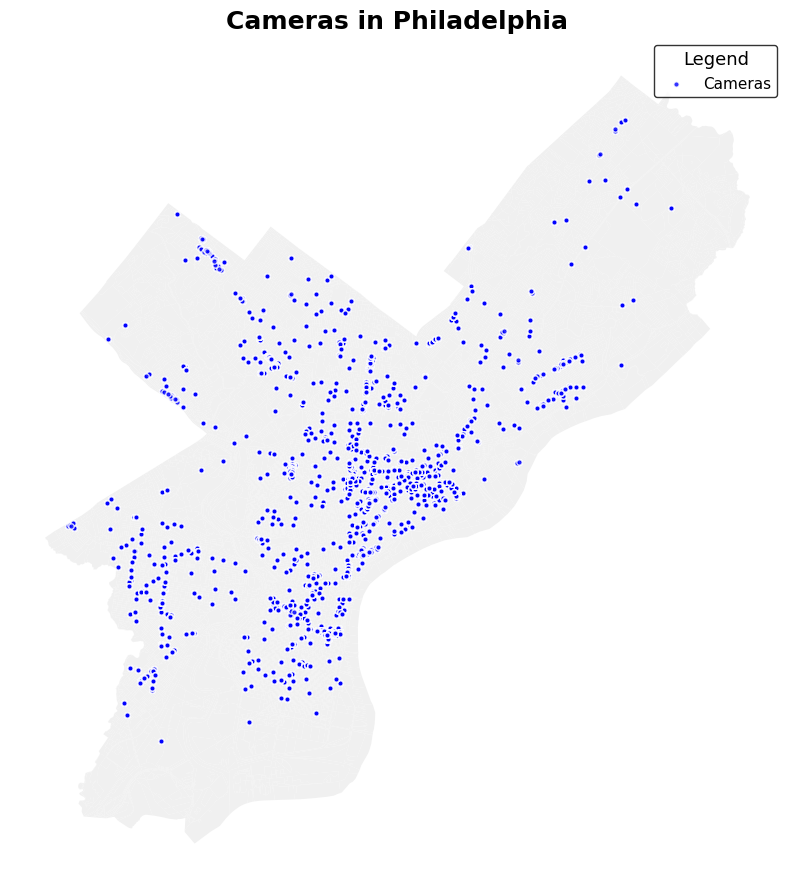

In [ ]:
# Step 1: Convert camera locations to GeoDataFrame
geometry = [Point(xy) for xy in zip(phC1['X'], phC1['Y'])]
camera_gdf = gpd.GeoDataFrame(phC1, crs="EPSG:4326", geometry=geometry)

# Step 2: Create a figure and axis to plot
fig, ax = plt.subplots(1, figsize=(10, 12))

# Step 3: Plot the Philly base shapefile as the background with improved styling
Philly_shp.plot(ax=ax, color='#f0f0f0', edgecolor='#B5C0D0', linewidth=0, label="Philadelphia Base Map")

# Step 4: Plot the cameras as a scatter plot with improved marker styling
camera_gdf.plot(ax=ax, color='blue', markersize=15, marker='o', label="Cameras", alpha=0.8, edgecolor='white')

# Step 5: Customize the title, font sizes, and overall plot aesthetics
ax.set_title("Cameras in Philadelphia", fontsize=18, fontweight='bold')
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

# Step 6: Add a legend, increase its size and position it properly
legend = ax.legend(title="Legend", title_fontsize='13', fontsize='11', loc='upper right', frameon=True)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)

# Step 7: Add a neat border around the map
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the final refined plot
plt.show()


##Let's take a look how the neighborhood in Philadelphia look like!

Plotting Business Cameras across various neighborhoods of Philadelphia

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Philadelphia Neighborhoods and Cameras')

[]

[]

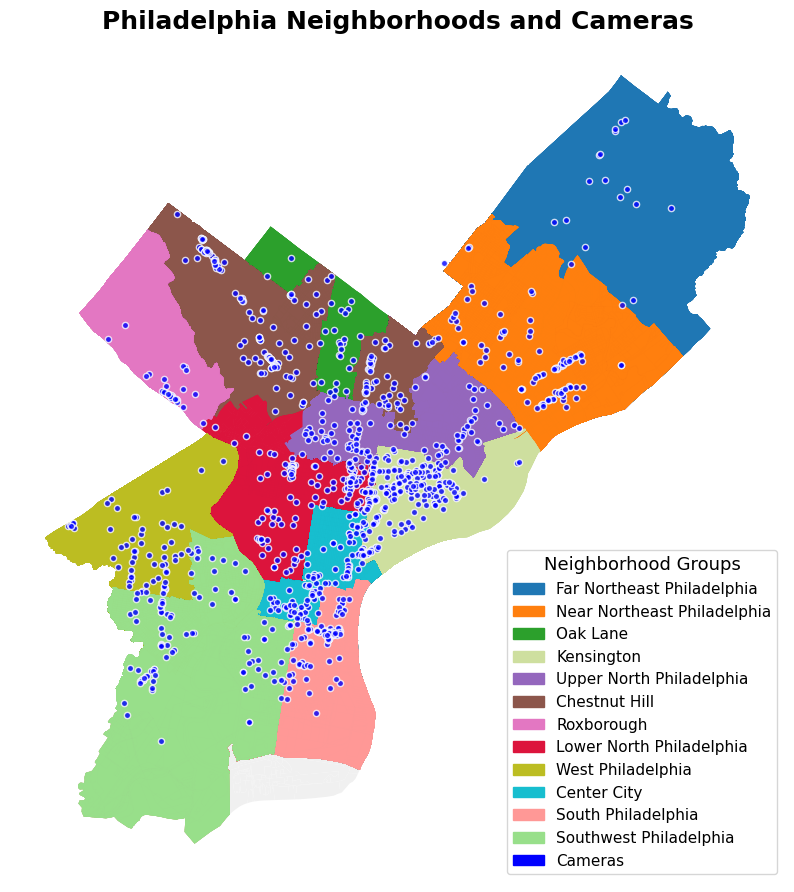

In [ ]:
# Step 1: Convert camera locations to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_BCam['X'], df_BCam['Y'])]
camera_gdf = gpd.GeoDataFrame(df_BCam, crs="EPSG:4326", geometry=geometry)

# Step 2: Define neighborhood groups and their respective colors
neighborhood_groups = {
    'Far Northeast Philadelphia': [
        'Academy Gardens', 'Bustleton', 'Byberry', 'Crestmont Farms', 'Morrell Park', 'Parkwood',
        'Somerton', 'Torresdale', 'Ashton Woodenbridge', 'Burholme',
        'Crescentville', 'Krewstown', 'Lawndale', 'Millbrook',
        'Modena', 'Normandy Village', 'North Torresdale', 'Northeast Philadelphia Airport',
        'Northwood', 'Oxford Circle', 'Pennypack Park', 'Pennypack Woods', 'Ryers',
        'Stanton', 'Walton Park', 'West Torresdale', 'Winchester Park','Mechanicsville'
    ],
    'Near Northeast Philadelphia': [
        'Castor Gardens', 'Fox Chase', 'Holmesburg', 'Mayfair', 'Rhawnhurst', 'Tacony',
        'Frankford', 'Wissinoming', 'Lawncrest', 'McGuire', 'Summerdale',
        'Lexington Park'
    ],
    'Oak Lane': [
        'East Oak Lane', 'West Oak Lane', 'Fern Rock', 'Ogontz', 'Logan', 'Cedarbrook'
    ],
    'Kensington': [
        'Kensington', 'East Kensington', 'West Kensington', 'Upper Kensington', 'Harrowgate',
        'Fishtown', 'Old Kensington', 'Port Richmond', 'Richmond', 'River Wards','Bridesburg'
    ],
    'Upper North Philadelphia': [
        'Allegheny West', 'Fairhill', 'Hunting Park', 'Nicetown', 'Tioga', 'Juniata Park',
        'Feltonville'
    ],
    'Chestnut Hill': [
        'Chestnut Hill', 'Blue Bell Hill', 'East Mount Airy', 'Germantown - East',
        'Germantown - Morton', 'Germantown - Southwest', 'Germantown - West Central',
        'Germantown - Westside', 'Olney', 'Penn Knox', 'West Mount Airy', 'Wissahickon Park', 'Wister'
    ],
    'Roxborough': [
        'Andorra', 'Manayunk', 'Wissahickon', 'Roxborough', 'Upper Roxborough', 'Dearnley Park',
        'Germany Hill', 'Roxborough Park', 'Wissahickon Hills'
    ],
    'Lower North Philadelphia': [
        'North Central', 'Brewerytown', 'Sharswood', 'Strawberry Mansion', 'Glenwood', 'Ludlow',
        'East Falls', 'East Poplar', 'Fairmount', 'Francisville', 'Spring Garden', 'Hartranft'
    ],
    'West Philadelphia': [
        'Belmont', 'Cobbs Creek', 'Dunlap', 'East Parkside', 'Haddington', 'Mantua', 'Mill Creek',
        'Overbrook', 'Powelton', 'Saunders Park', 'Spruce Hill', 'Walnut Hill', 'University City',
        'Wynnefield', 'West Parkside', 'West Poplar', 'West Powelton', 'Kingsessing', 'Carroll Park',
        'Cathedral Park', 'Cedar Park', 'Garden Court', 'Haverford North', 'West Park',
        'Wynnefield Heights'
    ],
    'Center City': [
        'Avenue of the Arts North', 'Avenue of the Arts South', 'Center City', 'Center City East',
        'Center City West', 'Chinatown', 'Logan Square', 'Old City', 'Rittenhouse',
        'Society Hill', 'Washington Square West', 'Callowhill', 'Christian Street Historic District',
        'Fitler Square', 'Graduate Hospital', 'Greenwich', 'Northern Liberties',
        'Yorktown'
    ],
    'South Philadelphia': [
        'Bella Vista', 'Dickinson Narrows', 'East Passyunk Crossing', 'Girard Estates',
        'Lower Moyamensing', 'Marconi Plaza', 'Newbold', 'Passyunk Square', 'Pennsport',
        'Point Breeze', 'Queen Village', 'Stadium District', 'Whitman', 'Hawthorne',
        'Italian Market', 'Little Saigon', 'Packer Park', 'Passyunk', 'Penrose', 'Riverfront',
        'West Passyunk'
    ],
    'Southwest Philadelphia': [
        'Bartram Village', 'Elmwood', 'Grays Ferry', 'Paschall', 'Southwest Schuylkill',
        'Kingsessing', 'Angora', 'Clearview', 'Devil\'s Pocket', 'Eastwick', 'Mount Moriah',
        'Naval Square', 'Woodland Terrace'
    ]
}

region_colors = {
    'Far Northeast Philadelphia': '#1f77b4',
    'Near Northeast Philadelphia': '#ff7f0e',
    'Oak Lane': '#2ca02c',
    'Kensington': '#CEDF9F',
    'Upper North Philadelphia': '#9467bd',
    'Chestnut Hill': '#8c564b',
    'Roxborough': '#e377c2',
    'Lower North Philadelphia': '#dc143c',
    'West Philadelphia': '#bcbd22',
    'Center City': '#17becf',
    'South Philadelphia': '#ff9896',
    'Southwest Philadelphia': '#98df8a'
}


# Create a new column 'Region' based on the neighborhood groupings
phC1['Region'] = phC1['Neighborhood'].apply(lambda x: next((key for key, value in neighborhood_groups.items() if x in value), 'Other'))

# Step 3: Create a figure and axis to plot
fig, ax = plt.subplots(1, figsize=(10, 12))

# Step 4: Plot the Philly base shapefile as the background
Philly_shp.plot(ax=ax, color='#f0f0f0', edgecolor='#B5C0D0', linewidth=0)

# Plot each region with its corresponding color
for region, color in region_colors.items():
    phC1[phC1['Region'] == region].plot(ax=ax, color=color, edgecolor='grey', linewidth=0)

# Step 6: Plot the cameras as a scatter plot
camera_gdf.plot(ax=ax, color='blue', markersize=15, marker='o', alpha=0.8, edgecolor='white')

# Step 7: Add a custom legend for neighborhood groups (regions)
patches = [mpatches.Patch(color=color, label=region) for region, color in region_colors.items()]
camera_patch = mpatches.Patch(color='blue', label='Cameras')  # Add legend for cameras
patches.append(camera_patch)
ax.legend(handles=patches, title="Neighborhood Groups", title_fontsize='13', fontsize='11', loc='lower right', frameon=True)

# Step 8: Customize the title and remove ticks
ax.set_title("Philadelphia Neighborhoods and Cameras", fontsize=18, fontweight='bold')
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

# Add a neat border around the map
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the final refined plot
plt.show()



##Let's take the crime rates into consideration, but why is it important?
It serves as a key indicator of neighborhood safety and stability.

Here’s how the crime data contributed to the overall socioeconomic analysis and neighborhood classification.

Before performing the analysis, let's see what the existing situation in Philadelphia w.r.t crime looks like -
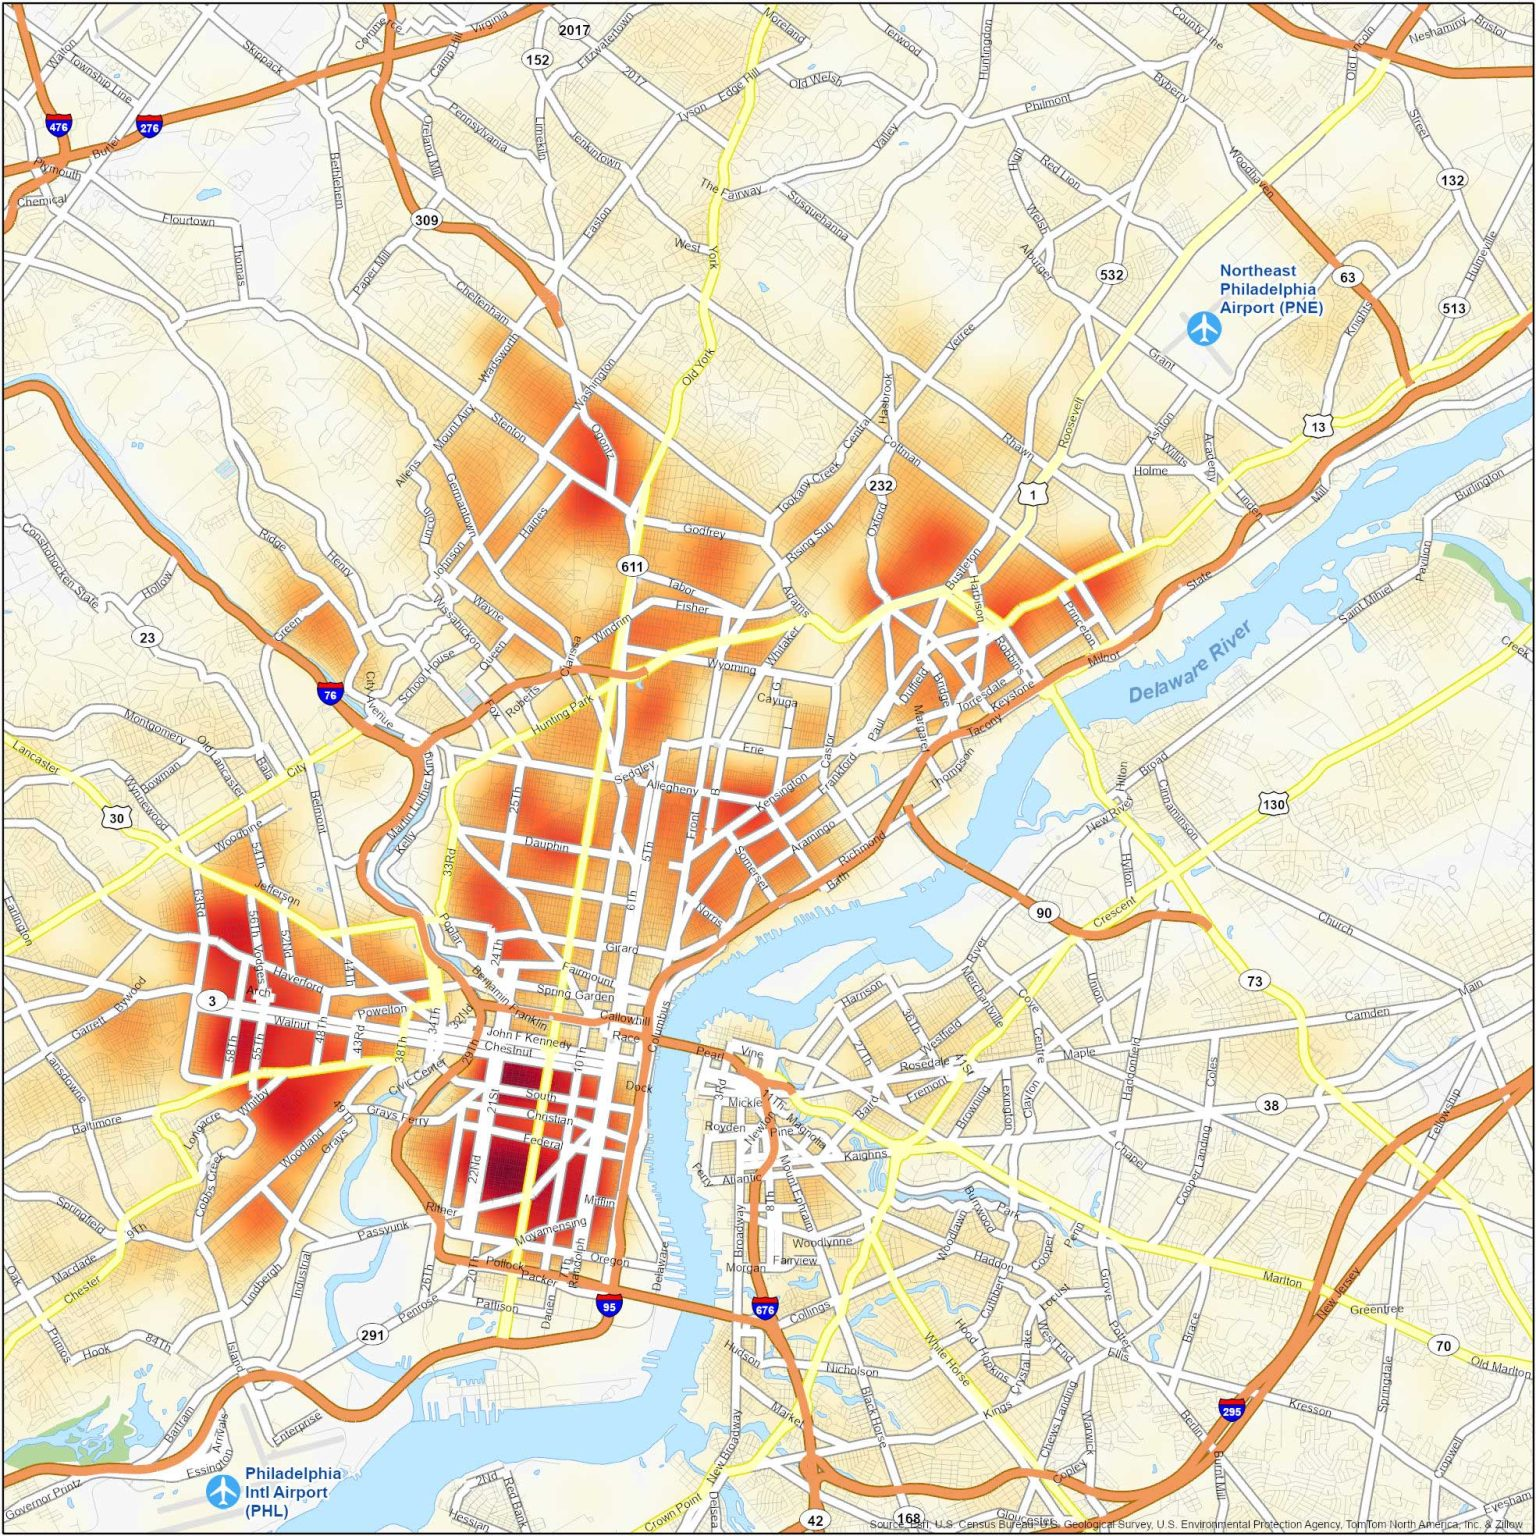

In [25]:
df_crime = pd.read_csv('https://phl.carto.com/api/v2/sql?filename=incidents_part1_part2&format=csv&q=SELECT%20*%20,%20ST_Y(the_geom)%20AS%20lat,%20ST_X(the_geom)%20AS%20lng%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date_time%20%3E=%20%272023-01-01%27%20AND%20dispatch_date_time%20%3C%20%272024-01-01%27')
df_crime.columns

Index(['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'dc_dist',
       'psa', 'dispatch_date_time', 'dispatch_date', 'dispatch_time', 'hour',
       'dc_key', 'location_block', 'ucr_general', 'text_general_code',
       'point_x', 'point_y', 'lat', 'lng'],
      dtype='object')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Crime Incidents in Philadelphia')

[]

[]

<ipython-input-15-14cf79d838ae>:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


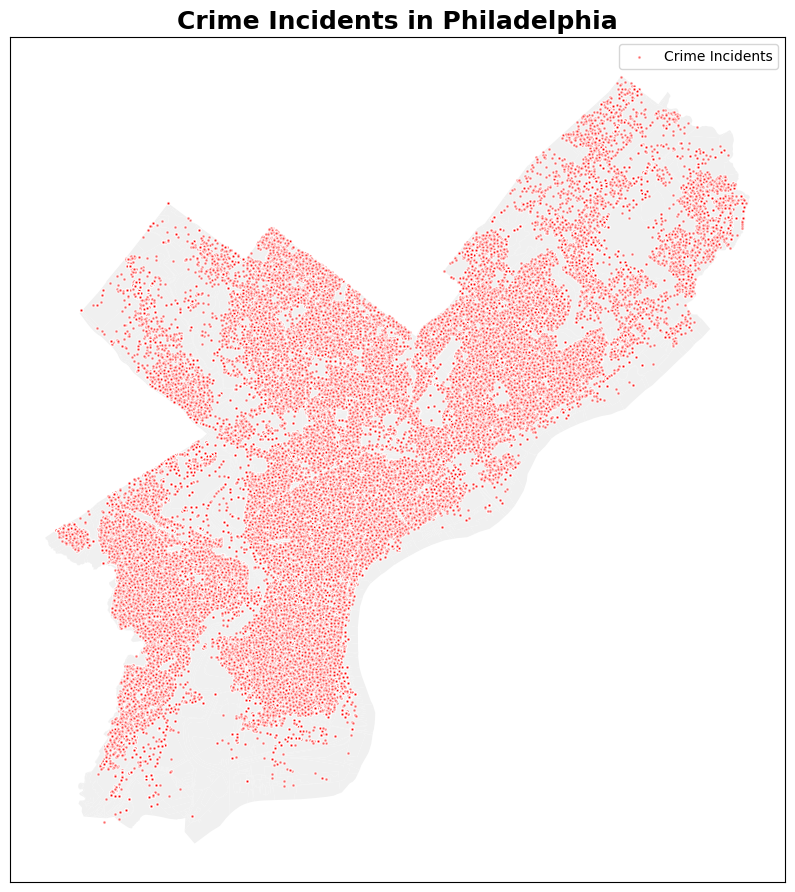

In [ ]:
geometry = [Point(xy) for xy in zip(df_crime['lng'], df_crime['lat'])]
crime_gdf = gpd.GeoDataFrame(df_crime, crs="EPSG:4326", geometry=geometry)

# Step 2: Create a figure and axis to plot
fig, ax = plt.subplots(1, figsize=(10, 12))

# Step 3: Plot the base map (Philly neighborhoods, for example)
Philly_shp.plot(ax=ax, color='#f0f0f0', edgecolor='#B5C0D0', linewidth=0, label="Philadelphia Base Map")

# Step 4: Plot the crime data as red points
crime_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.6, label="Crime Incidents", edgecolor='white')

# Step 5: Customize the map
ax.set_title("Crime Incidents in Philadelphia", fontsize=18, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

# Show the plot
plt.show()

Overlaying Cameras and Crimes for better understanding

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Crime and Cameras in Philadelphia')

[]

[]

<ipython-input-32-ce91b85a50b3>:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = ax.legend(title="Legend", title_fontsize='13', fontsize='11', loc='upper right', frameon=True)


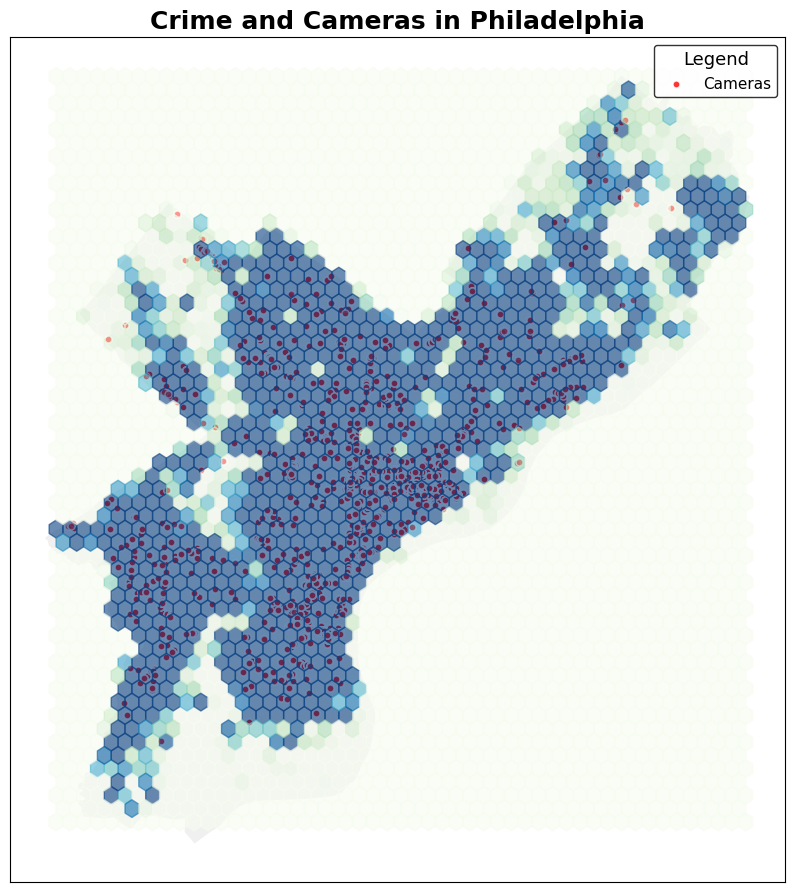

In [ ]:
# Step 1: Convert camera data to GeoDataFrame
camera_geometry = [Point(xy) for xy in zip(phC1['X'], phC1['Y'])]
camera_gdf = gpd.GeoDataFrame(phC1, crs="EPSG:4326", geometry=camera_geometry)

# Step 2: Convert crime data to GeoDataFrame
crime_geometry = [Point(xy) for xy in zip(df_crime['lng'], df_crime['lat'])]
crime_gdf = gpd.GeoDataFrame(df_crime, crs="EPSG:4326", geometry=crime_geometry)

# Step 3: Create a figure and axis to plot
fig, ax = plt.subplots(1, figsize=(10, 12))

# Step 4: Plot the base map (Philly neighborhoods)
Philly_shp.plot(ax=ax, color='#f0f0f0',linewidth = 0 ,edgecolor='#B5C0D0', label="Philadelphia Base Map")

# Step 5: Plot camera locations as scatter points
camera_gdf.plot(ax=ax, color='red', markersize=25, marker='o', label="Cameras", alpha=0.8, edgecolor='white')

# Step 6: Plot crime data using hexbin with increased intensity (you can adjust gridsize and cmap)
x = crime_gdf.geometry.x
y = crime_gdf.geometry.y

# Adjust the color map and set vmin and vmax for intensity control
plt.hexbin(x, y, gridsize=50, cmap='GnBu', alpha=0.6, vmin=2, vmax=50)

# Step 7: Customize the plot
ax.set_title("Crime and Cameras in Philadelphia", fontsize=18, fontweight='bold')
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

# Step 8: Add a legend for cameras (since hexbin has its own color mapping)
legend = ax.legend(title="Legend", title_fontsize='13', fontsize='11', loc='upper right', frameon=True)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)

# Show the plot
plt.show()



Taking two important public sectors into consideration - Schools and Primary Health Centers

In [26]:
df_School = pd.read_csv('https://opendata.arcgis.com/api/v3/datasets/d46a7e59e2c246c891fbee778759717e_0/downloads/data?format=csv&spatialRefId=4326')
df_Health = pd.read_csv('https://opendata.arcgis.com/datasets/f87c257e1039470a8a472694c2cd2e4f_0.csv')
df_School['ZIP_CODE'] = df_School['ZIP_CODE'].astype(str)
df_Health['ZIP'] = df_Health['ZIP'].astype(str)

In [27]:
# Count number of entries in each zip code for schools, health centers, and cameras
school_count = df_School.groupby('ZIP_CODE').size().reset_index(name='school_count')
health_center_count = df_Health.groupby('ZIP').size().reset_index(name='health_center_count')
camera_count= df_BCam.groupby('in_zip').size().reset_index(name='camera_count')

# Merge these counts into the zip code GeoDataFrame
Philly_shp = Philly_shp.merge(school_count, how='left', left_on='ZCTA5CE20', right_on='ZIP_CODE')
Philly_shp = Philly_shp.merge(health_center_count, how='left', left_on='ZCTA5CE20', right_on='ZIP')
Philly_shp = Philly_shp.merge(camera_count, how='left', left_on='ZCTA5CE20', right_on='in_zip')

Histogram showing Distribution of Cameras across neighborhoods near Schools and Health Centers

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='camera_count', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Cameras in Zip Codes near Schools and Health Centers')

Text(0.5, 0, 'Number of Cameras')

Text(0, 0.5, 'Number of Zip Codes')

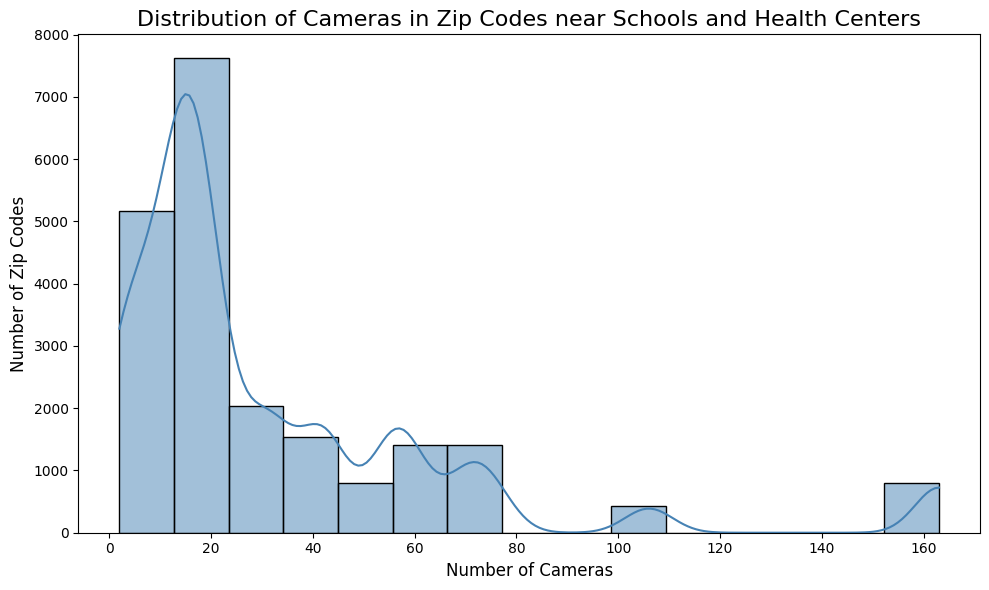

In [ ]:
data_for_histogram = Philly_shp[['ZCTA5CE20', 'camera_count', 'school_count', 'health_center_count']].copy()

data_for_histogram['total_institutions'] = data_for_histogram['school_count'].fillna(0) + data_for_histogram['health_center_count'].fillna(0)

plt.figure(figsize=(10, 6))
sns.histplot(data_for_histogram['camera_count'], bins=15, color='steelblue', kde=True)

plt.title('Distribution of Cameras in Zip Codes near Schools and Health Centers', fontsize=16)
plt.xlabel('Number of Cameras', fontsize=12)
plt.ylabel('Number of Zip Codes', fontsize=12)

plt.tight_layout()
plt.show()

The median household income data is a foundational component of this analysis, offering critical insights into the economic well-being of Philadelphia’s neighborhoods.

In [28]:
economy_df = pd.read_csv('https://raw.githubusercontent.com/naimish75/GIS/main/Economy.csv')
economy_df.head()

zip  income_household_median  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0  19102                 115597.0         NaN         NaN         NaN   
1  19103                  83988.0         NaN         NaN         NaN   
2  19104                  30734.0         NaN         NaN         NaN   
3  19106                 126287.0         NaN         NaN         NaN   
4  19107                  62280.0         NaN         NaN         NaN   

   Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  \
0         NaN         NaN         NaN         NaN         NaN          NaN   
1         NaN         NaN         NaN         NaN         NaN          NaN   
2         NaN         NaN         NaN         NaN         NaN          NaN   
3         NaN         NaN         NaN         NaN         NaN          NaN   
4         NaN         NaN         NaN         NaN         NaN          NaN   

   Unnamed: 11  Unnamed: 12  Unnamed: 13  Unnamed: 14  
0          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN

In [29]:
economy_df['zip'] = economy_df['zip'].astype(str)

Economy_Philly = phC1.merge(economy_df, left_on='ZCTA5CE20', right_on='zip', how='left')
Economy_Philly.head()

Neighborhood          X          Y ZCTA5CE20  \
0    Clearview -75.242744  39.912451     19153   
1    Clearview -75.242744  39.912451     19153   
2     Eastwick -75.242744  39.912451     19153   
3     Eastwick -75.242744  39.912451     19153   
4      Penrose -75.242744  39.912451     19153   

                                            geometry    zip  \
0  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  19153   
1  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  19153   
2  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  19153   
3  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  19153   
4  POLYGON ((-75.25278 39.87699, -75.25206 39.877...  19153   

   income_household_median  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0              57830.00000         NaN         NaN         NaN         NaN   
1                 39.88391         NaN         NaN         NaN         NaN   
2              57830.00000         NaN         NaN         NaN         NaN   
3                 39.88391         NaN         NaN         NaN         NaN   
4              57830.00000         NaN         NaN         NaN         NaN   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0         NaN         NaN         NaN         NaN          NaN          NaN   
1         NaN         NaN         NaN         NaN          NaN          NaN   
2         NaN         NaN         NaN         NaN          NaN          NaN   
3         NaN         NaN         NaN         NaN          NaN          NaN   
4         NaN         NaN         NaN         NaN          NaN          NaN   

   Unnamed: 12  Unnamed: 13  Unnamed: 14  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

Merging Household Income data with the main dataset

In [30]:
Economy_Philly=Economy_Philly[['Neighborhood','X','Y','ZCTA5CE20','geometry','income_household_median']]
Economy_Philly.head()

Neighborhood          X          Y ZCTA5CE20  \
0    Clearview -75.242744  39.912451     19153   
1    Clearview -75.242744  39.912451     19153   
2     Eastwick -75.242744  39.912451     19153   
3     Eastwick -75.242744  39.912451     19153   
4      Penrose -75.242744  39.912451     19153   

                                            geometry  income_household_median  
0  POLYGON ((-75.25278 39.87699, -75.25206 39.877...              57830.00000  
1  POLYGON ((-75.25278 39.87699, -75.25206 39.877...                 39.88391  
2  POLYGON ((-75.25278 39.87699, -75.25206 39.877...              57830.00000  
3  POLYGON ((-75.25278 39.87699, -75.25206 39.877...                 39.88391  
4  POLYGON ((-75.25278 39.87699, -75.25206 39.877...              57830.00000

Choropleth map of the income distribution across neighborhoods suitable for visualizing general trends in income variation across the city.

<Axes: >

Text(0.5, 1.0, 'Income Category Map by Neighborhood')

(-75.29649115, -74.93953785000001, 39.8534546, 40.1515414)

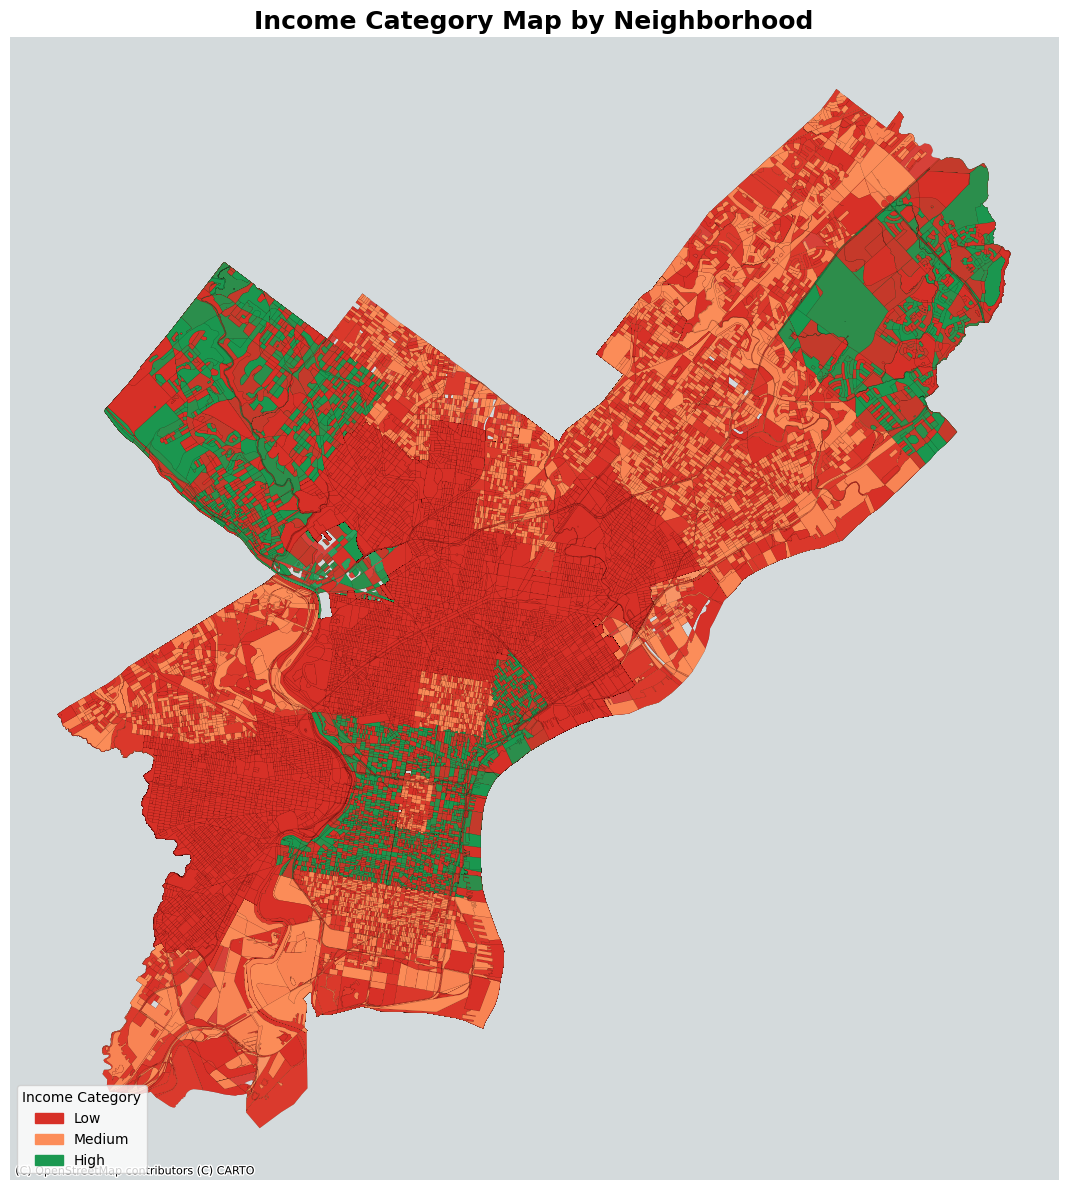

In [ ]:
# Sample and categorize data
Economy_Phily_sample = Economy_Philly.sample(frac=0.3, random_state=42)

def categorize_income_simple(income):
    if income < 40000:
        return 'Low'
    elif 40000 <= income < 70000:
        return 'Medium'
    else:
        return 'High'

Economy_Phily_sample['income_category'] = Economy_Phily_sample['income_household_median'].apply(categorize_income_simple)

# Define refined color scheme for income categories
income_colors = {
    'Low': '#D73027',  # Red for low income
    'Medium': '#FC8D59',  # Orange for medium income
    'High': '#1A9850'  # Green for high income
}

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Plot neighborhoods with income categories, adding transparency and thinner borders
Economy_Phily_sample.plot(
    ax=ax,
    color=Economy_Phily_sample['income_category'].map(income_colors),
    edgecolor='black',
    linewidth=0.05,  # Thin borders to reduce clutter
    alpha=0.9  # Slight transparency for a softer appearance
)

# Use CartoDB.Positron basemap with a low zoom level to reduce detail
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  # Simplified basemap
    zoom=10  # Reduced zoom level for only major roads
)

# Create a legend manually
legend_elements = [mpatches.Patch(color=income_colors[cat], label=cat) for cat in income_colors.keys()]
ax.legend(handles=legend_elements, title="Income Category", loc='lower left', fontsize=10, frameon=True, fancybox=True, framealpha=0.8)

# Customize the plot
ax.set_title("Income Category Map by Neighborhood", fontsize=18, fontweight='bold')
ax.axis("off")  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()



Now let's visualize neighborhoods based on "Low Income", Medium Income", and "High Income" with their respective Crime Rates through a interactive pie-chart

In [32]:
Economy_Phily_sample = Economy_Philly.sample(frac=0.3, random_state=42)

Economy_Philly_sample = Economy_Phily_sample.to_crs("EPSG:4326")

crime_gdf_neighborhoods = gpd.sjoin(crime_gdf, Economy_Phily_sample[['Neighborhood', 'geometry']], how="left", predicate="within")

crime_counts = crime_gdf_neighborhoods.groupby("Neighborhood").size().reset_index(name="crime_count")

income_crime_df = Economy_Phily_sample.merge(crime_counts, on="Neighborhood", how="left")
income_crime_df['income_level'] = pd.cut(
    income_crime_df['income_household_median'],
    bins=[0, 40000, 70000, income_crime_df['income_household_median'].max()],
    labels=['Low Income', 'Medium Income', 'High Income']
)

# Select top neighborhoods by crime count within each income level
top_low_income = income_crime_df[income_crime_df['income_level'] == 'Low Income'].nlargest(3, 'crime_count')
top_medium_income = income_crime_df[income_crime_df['income_level'] == 'Medium Income'].nlargest(3, 'crime_count')
top_high_income = income_crime_df[income_crime_df['income_level'] == 'High Income'].nlargest(4, 'crime_count')

# Combine the selections to get a mix of high, medium, and low income neighborhoods
top_neighborhoods_mixed = pd.concat([top_low_income, top_medium_income, top_high_income])

# Create the pie chart with the filtered neighborhoods
fig = px.pie(
    top_neighborhoods_mixed,
    names="Neighborhood",
    values="crime_count",
    color="income_level",
    color_discrete_map={
        "Low Income": "lightcoral",
        "Medium Income": "gold",
        "High Income": "lightgreen"
    },
    title="Top Neighborhoods by Crime Count Across Different Income Levels"
)

# Explode slices for high crime counts
fig_1 = fig.update_traces(
    pull=[0.1 if count > top_neighborhoods_mixed['crime_count'].quantile(0.75) else 0 for count in top_neighborhoods_mixed['crime_count']],
    textinfo='percent+label',
    hovertemplate="<b>%{label}</b><br>Crime Count: %{value}<br>Income Level: %{color}"
)

# Display the figure
fig_1.show()

<ipython-input-32-525d01c5ccc6>:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  crime_gdf_neighborhoods = gpd.sjoin(crime_gdf, Economy_Phily_sample[['Neighborhood', 'geometry']], how="left", predicate="within")


Assessing graduation rates from selected Philadelphia schools as a proxy for neighborhood educational attainment



In [33]:
df_grad = pd.read_csv('https://raw.githubusercontent.com/naimish75/GIS/main/Grad_data.csv')
df_grad.head()

GeoID_Description  GeoID_Name SitsinState  GeoID GeoID_Formatted  \
0  Zip Code Tabulation Area       19102          PA  19102        ="19102"   
1  Zip Code Tabulation Area       19103          PA  19103        ="19103"   
2  Zip Code Tabulation Area       19104          PA  19104        ="19104"   
3  Zip Code Tabulation Area       19106          PA  19106        ="19106"   
4  Zip Code Tabulation Area       19107          PA  19107        ="19107"   

    phsp  TimeFrame  GeoVintage  Source                     Location  
0  98.38  2018-2022        2020  Census  Philadelphia (County, 2022)  
1  98.08  2018-2022        2020  Census  Philadelphia (County, 2022)  
2  88.91  2018-2022        2020  Census  Philadelphia (County, 2022)  
3  95.36  2018-2022        2020  Census  Philadelphia (County, 2022)  
4  90.45  2018-2022        2020  Census  Philadelphia (County, 2022)

The histogram visualizing the "High School Diploma Rate (%)" provides valuable insights into the distribution of high school diploma attainment across the data - this chart is particularly useful for quickly assessing the overall educational landscape and prioritizing areas needing improvement.

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='phsp', ylabel='Count'>

Text(0.5, 0, 'High School Diploma Rate (%)')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of High School Diploma Rates')

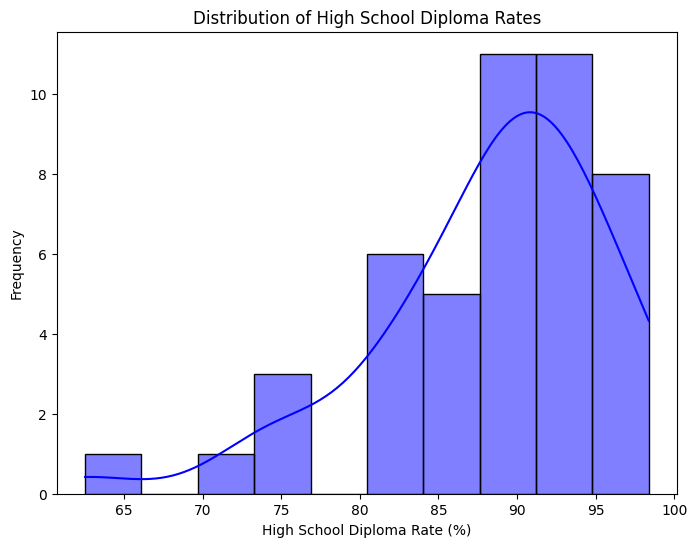

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_grad, x='phsp', bins=10, kde=True, color='blue')
plt.xlabel("High School Diploma Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of High School Diploma Rates")
plt.show()


<Axes: >

Text(0.5, 1.0, 'High School Diploma Rates by Zip Code in Philadelphia')

(-75.29649115, -74.93953785000001, 39.8795324, 40.1502996)

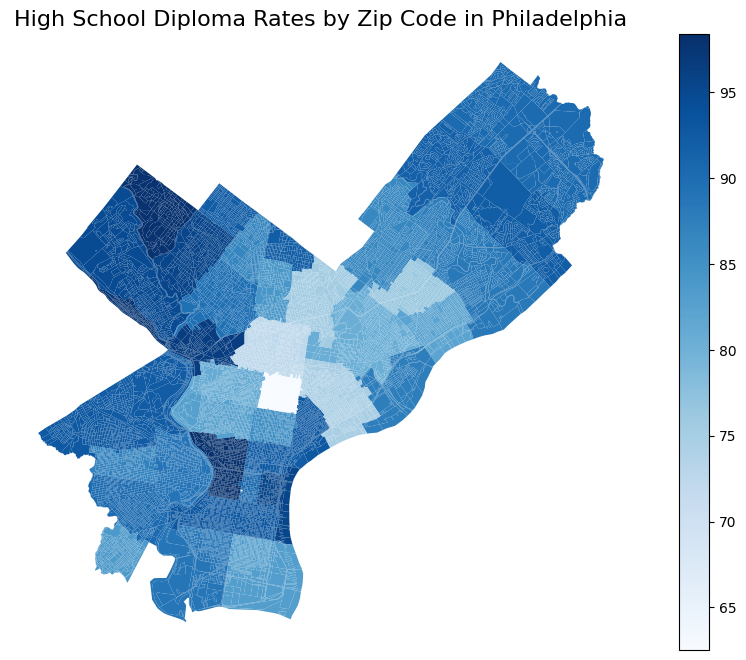

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ensure both columns are the same type
Philly_shp['ZCTA5CE20'] = Philly_shp['ZCTA5CE20'].astype(str)
df_grad['GeoID'] = df_grad['GeoID'].astype(str)

# Merge shapefile with your data
philly_data = Philly_shp.merge(df_grad, left_on='ZCTA5CE20', right_on='GeoID', how='left')

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
philly_data.plot(
    column='phsp',
    cmap='Blues',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0
)
ax.set_title("High School Diploma Rates by Zip Code in Philadelphia", fontsize=16)
ax.axis("off")

# Display the plot
plt.show()


Visualizing Overall Graduation Rate and Dropout Rate through a gauge chart

In [ ]:
import plotly.graph_objects as go

# Calculate overall graduation rate based on 'phsp'
overall_graduation_rate = df_grad['phsp'].mean()  # Average percentage of high school diploma rates
overall_dropout_rate = 100 - overall_graduation_rate  # Complementary rate as a percentage

# Create the dual gauge chart
fig = go.Figure()

# Graduation rate gauge (left)
fig_1 = fig.add_trace(go.Indicator(
    mode="gauge+number",
    value=overall_graduation_rate,
    title={'text': "Graduation Rate", 'font': {'size': 16}},
    domain={'x': [0, 0.45], 'y': [0, 1]},  # Position on the left
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': "blue"},
        'steps': [
            {'range': [0, 50], 'color': "lightgray"},
            {'range': [50, 75], 'color': "lightblue"},
            {'range': [75, 100], 'color': "royalblue"}
        ],
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': overall_graduation_rate}
    }
))

# Dropout rate gauge (right)
fig_2 = fig_1.add_trace(go.Indicator(
    mode="gauge+number",
    value=overall_dropout_rate,
    title={'text': "Dropout Rate", 'font': {'size': 16}},
    domain={'x': [0.55, 1], 'y': [0, 1]},  # Position on the right
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': "crimson"},
        'steps': [
            {'range': [0, 50], 'color': "lightgray"},
            {'range': [50, 75], 'color': "salmon"},
            {'range': [75, 100], 'color': "red"}
        ],
        'threshold': {
            'line': {'color': "darkred", 'width': 4},
            'thickness': 0.75,
            'value': overall_dropout_rate}
    }
))

# Customize layout to ensure only one combined figure is displayed
fig_3 = fig_2.update_layout(
    title_text="Overall Graduation and Dropout Rates",
    paper_bgcolor="whitesmoke",
    font={'color': "darkblue", 'family': "Arial"},
    margin={'t': 60, 'b': 20, 'l': 20, 'r': 20}
)

# Show the single, dual-gauge figure
fig_3.show()


Before we dive in Housing Rates let's reflect on previous works to see what the Housing Market Value Scenario looked like -
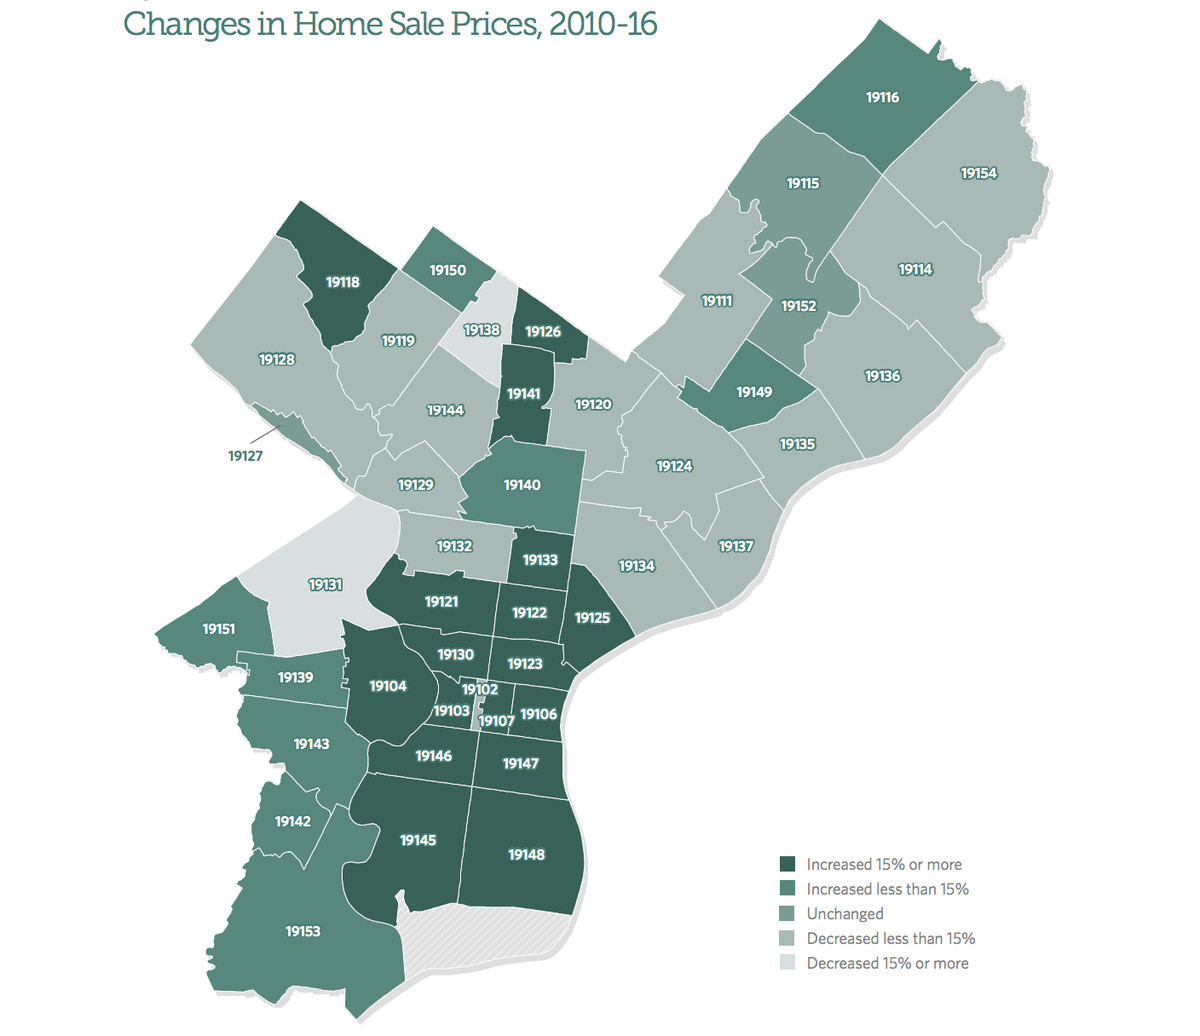


For instance, this map shows the Housing Market Values in Philadelphia during the period 2010-16.
We can clearly see that Housing Values are a direct reflection of a neighborhood’s economic condition, thereby revealing the spatial distribution of wealth and economic inequality across the county.

So let's analyze this dimension to get a better understanding of the socioeconomic landscape in Philadelphia!


In [34]:
df_house = pd.read_csv('https://opendata-downloads.s3.amazonaws.com/opa_properties_public.csv')
df_house = df_house[[
    'location', 'zip_code', 'census_tract', 'geographic_ward',
    'number_of_bathrooms', 'number_of_bedrooms', 'number_of_rooms',
    'number_stories', 'total_livable_area', 'year_built',
    'market_value', 'sale_date', 'sale_price',
    'building_code_description', 'category_code_description',
    'quality_grade', 'owner_1', 'mailing_city_state'
]]
df_house.head()

<ipython-input-34-894d3611576d>:1: DtypeWarning:

Columns (4,16,25,27,76) have mixed types. Specify dtype option on import or set low_memory=False.



location  zip_code  census_tract  geographic_ward  \
0   2168 N MARSTON ST   19121.0         151.0             32.0   
1  2035 N STILLMAN ST   19121.0         151.0             32.0   
2      1721 N 16TH ST   19121.0         147.0             47.0   
3  3729 S LAWRENCE ST       NaN           NaN              NaN   
4    5312-50 EADOM ST   19137.0         381.0             45.0   

   number_of_bathrooms  number_of_bedrooms  number_of_rooms  number_stories  \
0                  NaN                 NaN              NaN             NaN   
1                  NaN                 NaN              NaN             NaN   
2                  0.0                 0.0              NaN             1.0   
3                  NaN                 NaN              NaN             NaN   
4                  NaN                 NaN              NaN             NaN   

   total_livable_area  year_built  market_value                  sale_date  \
0                 NaN         NaN       30900.0  2071-01-14 00:00:00-05:00   
1                 NaN         NaN       59700.0  2071-01-11 00:00:00-05:00   
2              2540.0      1890.0      342400.0  2071-01-04 00:00:00-05:00   
3                 NaN         NaN      378900.0  2071-01-04 00:00:00-05:00   
4                 NaN         NaN      626400.0  2070-12-31 00:00:00-05:00   

   sale_price  building_code_description category_code_description  \
0         1.0  VACANT LAND RESIDE < ACRE               VACANT LAND   
1         1.0  VACANT LAND RESIDE < ACRE               VACANT LAND   
2     16200.0   ROW CONV/APT 3 STY MASON              MULTI FAMILY   
3         1.0   VACANT LAND RESIDE ACRE+               VACANT LAND   
4         1.0  NON PD PKG LOT COMMERCIAL               VACANT LAND   

  quality_grade                    owner_1 mailing_city_state  
0           NaN               WAYNE GADDIE    PHILADELPHIA PA  
1           NaN     PHILADELPHIA LAND BANK    PHILADELPHIA PA  
2            B-  PHILADELPHIA HOUSING AUTH    PHILADELPHIA PA  
3           NaN    REDEVELOPMENT AUTHORITY    PHILADELPHIA PA  
4           NaN              CITY OF PHILA    PHILADELPHIA PA

In [35]:
Economy_Phily_sample = Economy_Phily_sample.to_crs("EPSG:4326")

crime_gdf_neighborhoods = gpd.sjoin(crime_gdf, Economy_Phily_sample[['Neighborhood', 'geometry']], how="left", predicate="within")

crime_counts = crime_gdf_neighborhoods.groupby("Neighborhood").size().reset_index(name="crime_count")

income_crime_df = Economy_Phily_sample.merge(crime_counts, on="Neighborhood", how="left")
df_house = df_house.dropna(subset=['zip_code'])
income_crime_df = income_crime_df.dropna(subset=['ZCTA5CE20'])

# Step 2: Drop rows with infinite values in 'zip_code' or 'ZCTA5CE20'
df_house = df_house[~df_house['zip_code'].isin([np.inf, -np.inf])]
income_crime_df = income_crime_df[~income_crime_df['ZCTA5CE20'].isin([np.inf, -np.inf])]

# Step 3: Convert to string by first ensuring numeric conversion
df_house['zip_code'] = pd.to_numeric(df_house['zip_code'], errors='coerce').dropna().astype(int).astype(str)
income_crime_df['ZCTA5CE20'] = pd.to_numeric(income_crime_df['ZCTA5CE20'], errors='coerce').dropna().astype(int).astype(str)

In [36]:
sample_size = 10000  # Adjust this as needed
df_house_sample = df_house.sample(n=sample_size, random_state=1)
income_crime_sample = income_crime_df.sample(n=sample_size, random_state=1)

# Convert columns to strings for matching
income_crime_sample['ZCTA5CE20'] = income_crime_sample['ZCTA5CE20'].astype(str)
df_house_sample['zip_code'] = df_house_sample['zip_code'].astype(str)

# Select only essential columns for visualization
columns_to_keep = [
    'ZCTA5CE20', 'zip_code', 'location', 'market_value', 'sale_price',
    'number_of_bathrooms', 'number_of_bedrooms', 'quality_grade'
]


# Perform the join on the smaller sample
income_crime_sample = income_crime_sample.merge(df_house_sample, left_on='ZCTA5CE20', right_on='zip_code', how='inner')

# Display the resulting DataFrame
income_crime_sample.head()

Neighborhood          X          Y ZCTA5CE20  \
0     Richmond -75.116773  39.991293     19134   
1     Richmond -75.116773  39.991293     19134   
2     Richmond -75.116773  39.991293     19134   
3     Richmond -75.116773  39.991293     19134   
4     Richmond -75.116773  39.991293     19134   

                                            geometry  income_household_median  \
0  POLYGON ((-75.11393 39.99064, -75.11238 39.991...                  37821.0   
1  POLYGON ((-75.11393 39.99064, -75.11238 39.991...                  37821.0   
2  POLYGON ((-75.11393 39.99064, -75.11238 39.991...                  37821.0   
3  POLYGON ((-75.11393 39.99064, -75.11238 39.991...                  37821.0   
4  POLYGON ((-75.11393 39.99064, -75.11238 39.991...                  37821.0   

   crime_count             location zip_code  census_tract  ...  \
0       841361    1920 E CAMBRIA ST    19134         178.0  ...   
1       841361     3159 BELGRADE ST    19134         180.0  ...   
2       841361  600 E ALLEGHENY AVE    19134         177.0  ...   
3       841361        3133 ARBOR ST    19134         177.0  ...   
4       841361     2083 ALBRIGHT ST    19134         188.0  ...   

   total_livable_area  year_built  market_value                  sale_date  \
0              1519.0      1920.0      120700.0  1999-04-22 00:00:00-04:00   
1              1212.0      1920.0      230200.0  2019-09-24 00:00:00-04:00   
2              1472.0      1920.0       92400.0  2010-08-10 00:00:00-04:00   
3                 NaN         NaN       14200.0  1973-12-19 00:00:00-05:00   
4              1144.0      1920.0       92600.0  2018-11-13 00:00:00-05:00   

   sale_price  building_code_description  category_code_description  \
0         1.0          ROW 2 STY MASONRY              SINGLE FAMILY   
1         1.0          ROW 2 STY MASONRY              SINGLE FAMILY   
2    245000.0  ROW W/OFF STR 2 STY MASON                  MIXED USE   
3         1.0  VACANT LAND RESIDE < ACRE                VACANT LAND   
4     85000.0          ROW 2 STY MASONRY              SINGLE FAMILY   

   quality_grade          owner_1  mailing_city_state  
0             C   FILIPPINI LUIGI     PHILADELPHIA PA  
1             C   PLONSKI JOHANNA     PHILADELPHIA PA  
2             C           DBN LLC     PHILADELPHIA PA  
3            NaN     ANNA LAPTEFF       WOODBRIDGE VA  
4             C       PEREZ ERICA     PHILADELPHIA PA  

[5 rows x 25 columns]

In [37]:
income_crime_sample = income_crime_sample.sample(n=10000, random_state=42)

len(income_crime_sample)

10000

Scatter Plot with a Regression line to explore the relationship between Crime Count and Housing Market Value across neighborhoods

In [ ]:
x_vals = np.linspace(valid_data['log_crime_count'].min(), valid_data['log_crime_count'].max(), 100)
y_vals = slope * x_vals + intercept

# Create the scatter plot using Plotly
fig = go.Figure()

# Add scatter points
fig_1 = fig.add_trace(go.Scatter(
    x=valid_data['log_crime_count'],
    y=valid_data['log_market_value'],
    mode='markers',
    marker=dict(size=7, opacity=0.5, color='#6A1E55'),
    name='Data Points'
))

# Add regression line
fig_2 = fig_1.add_trace(go.Scatter(
    x=x_vals,
    y=y_vals,
    mode='lines',
    line=dict(color='red', width=2),
    name='Regression Line'
))

# Customize the layout
fig_final = fig_2.update_layout(
    title="Relationship Between Crime Count and Market Value",
    xaxis_title="Log of Crime Count",
    yaxis_title="Log of Market Value",
    legend=dict(x=0.8, y=1.1),
    template='plotly_white'
)

# Display the Plotly figure
fig_final.show()


 The scatter points’ distribution around the regression line shows the strength of the relationship. A tight cluster around the line indicates a stronger correlation, while a more dispersed set of points suggests a weaker relationship.

## Examining relationship between Crime Count, Housing Market Value, and Median Household Income through an interactive 3-D Scatterplot

1.   **Point size:**
The size of each point represents the crime count in that region.
Larger points indicate higher crime counts, while smaller points represent lower crime counts.


2.   **Key Findings from Previous Discussions**:



*   **A negative correlation was observed between Crime Count and Market Value:**
Areas with higher crime counts tend to have lower market values.
This aligns with the economic theory that higher crime can reduce property desirability and thus market value.
*   **Median Household Income also varies significantly:**
Higher-income neighborhoods tend to have both higher market values and lower crime counts, reinforcing socio-economic inequality trends.
Underdeveloped neighborhoods show a clustering of high crime counts and lower market values, while developed regions are the opposite.






In [ ]:
sample_data = income_crime_sample.sample(n=100, random_state=42)
sample_data['scaled_crime_count'] = (sample_data['crime_count'] - sample_data['crime_count'].min()) / \
                                    (sample_data['crime_count'].max() - sample_data['crime_count'].min()) * 50 + 5

fig = px.scatter_3d(
    sample_data,
    x='log_crime_count',
    y='log_market_value',
    z='income_household_median',
    color='income_household_median',
    size='scaled_crime_count',
    title="3D Plot: Market Value, Crime Count, and Household Median Income",
    labels={
        'log_crime_count': 'Log of Crime Count',
        'log_market_value': 'Log of Market Value',
        'income_household_median': 'Median Household Income',
        'scaled_crime_count': 'Scaled Crime Count'
    },
)

fig.show()

Identifying the relationships between housing market values, crime rates, and income levels to identify patterns that correlate with neighborhood development.

Text(0.5, 1.02, 'Scatter Plot Matrix of Housing Value, Crime Count, Income')

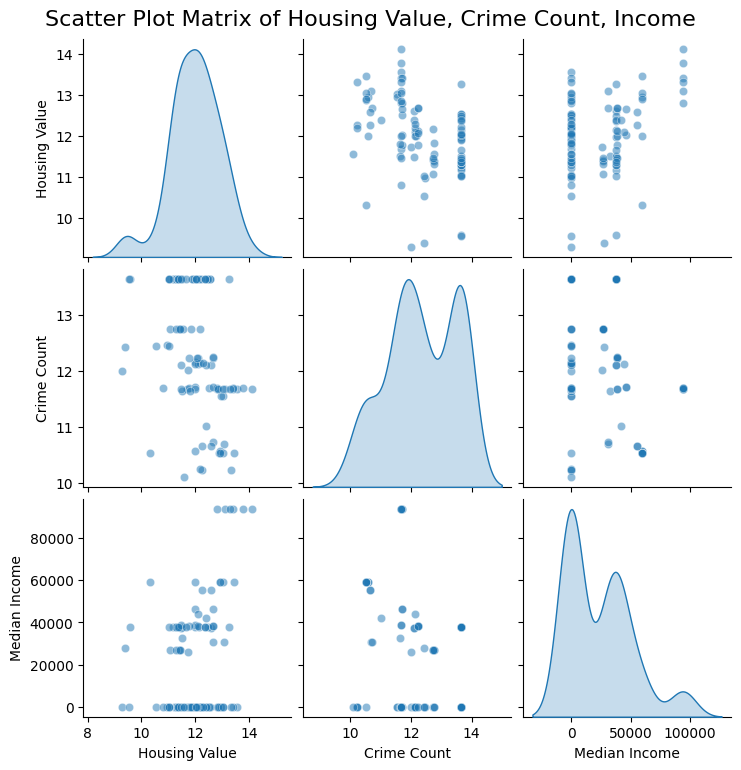

In [ ]:
data = sample_data[['log_market_value', 'log_crime_count', 'income_household_median']]
data.columns = ['Housing Value', 'Crime Count', 'Median Income']

# Plot the scatter plot matrix
sns.pairplot(data, diag_kind="kde", plot_kws={"alpha": 0.5})
plt.suptitle("Scatter Plot Matrix of Housing Value, Crime Count, Income", y=1.02, fontsize=16)
plt.show()

##Analyzing the correlation through a Heatmap!

Since we have more number of variables now, it will be really insightful to visualize the correlation amongst them through a heatmap.

In [ ]:
corr_data = income_crime_sample[['crime_count', 'income_household_median', 'market_value']].corr()

corr_long = corr_data.stack().reset_index()
corr_long.columns = ['Variable1', 'Variable2', 'Correlation']

fig = px.density_heatmap(
    corr_long, x='Variable1', y='Variable2', z='Correlation',
    color_continuous_scale='deep',
    title="Correlation Heatmap of Crime Count, Median Income, and Market Value"
)

fig_1 = fig.update_layout(
    width=600, height=500,
    xaxis_title="Variable",
    yaxis_title="Variable",
    coloraxis_colorbar=dict(title="Correlation")
)

fig_1.show()


##Diving into Folium!!

Classifying neighborhoods into Developed, Developing, or Under-Developed zones based on housing values, income levels, and crime rates.

**Method of Classification** - Used a **composite scoring approach**, normalizing each indicator (**income, housing value, crime**) and assigning weights to calculate a development score. This approach provided a single metric to gauge neighborhood development.

In [40]:
weights = {
    'income_household_median': 0.3,  # Higher income is better
    'market_value': 0.2,            # Higher housing value is better, moderate weight
    'crime_count': -0.2             # Lower crime count is better, negative weights
}
# Step 1: Log transform and normalize the metrics
income_crime_sample['log_income'] = np.log1p(income_crime_sample['income_household_median'])
income_crime_sample['log_market_value'] = np.log1p(income_crime_sample['market_value'])
income_crime_sample['log_crime'] = np.log1p(income_crime_sample['crime_count'])

income_crime_sample['income_normalized'] = income_crime_sample['log_income'] / income_crime_sample['log_income'].max()
income_crime_sample['housing_normalized'] = income_crime_sample['log_market_value'] / income_crime_sample['log_market_value'].max()
income_crime_sample['crime_normalized'] = 1 - (income_crime_sample['log_crime'] / income_crime_sample['log_crime'].max())

# Step 2: Calculate composite score
income_crime_sample['composite_score'] = (
    income_crime_sample['income_normalized'] * weights['income_household_median'] +
    income_crime_sample['housing_normalized'] * weights['market_value'] +
    income_crime_sample['crime_normalized'] * abs(weights['crime_count'])
)

# Step 3: Define thresholds for Developed, Developing, and Underdeveloped neighborhoods
income_crime_sample['development_category'] = pd.qcut(
    income_crime_sample['composite_score'],
    q=[0, 0.33, 0.66, 1],
    labels=['Underdeveloped', 'Developing', 'Developed']
)

# Select the top 5 neighborhoods in each category
top_developed = income_crime_sample[income_crime_sample['development_category'] == 'Developed'].nlargest(5, 'composite_score')
top_developing = income_crime_sample[income_crime_sample['development_category'] == 'Developing'].nlargest(5, 'composite_score')
top_underdeveloped = income_crime_sample[income_crime_sample['development_category'] == 'Underdeveloped'].nsmallest(5, 'composite_score')

# Combine the top neighborhoods into one dataframe
top_neighborhoods = pd.concat([top_developed, top_developing, top_underdeveloped])

# Step 4: Create a Folium map centered on Philadelphia
map_center = [income_crime_sample.geometry.centroid.y.mean(), income_crime_sample.geometry.centroid.x.mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Step 5: Add markers for each top neighborhood based on its development category
for idx, row in top_neighborhoods.iterrows():
    color = 'green' if row['development_category'] == 'Developed' else \
            'orange' if row['development_category'] == 'Developing' else 'red'
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=folium.Popup(
            f"<strong>{row['development_category']} Neighborhood</strong><br>"
            f"Neighborhood: {row['Neighborhood']}<br>"
            f"Median Income: ${row['income_household_median']:,}<br>"
            f"Housing Value: ${row['market_value']:,}<br>"
            f"Crime Count: {row['crime_count']}", max_width=300
        ),
        icon=folium.Icon(color=color),
    ).add_to(m)

# Display the map
m

<ipython-input-40-5d90daba8cde>:38: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [42]:
from folium.plugins import MarkerCluster

# Step 1: Log transform and normalize the metrics
income_crime_sample['log_income'] = np.log1p(income_crime_sample['income_household_median'])
income_crime_sample['log_market_value'] = np.log1p(income_crime_sample['market_value'])
income_crime_sample['log_crime'] = np.log1p(income_crime_sample['crime_count'])

income_crime_sample['income_normalized'] = income_crime_sample['log_income'] / income_crime_sample['log_income'].max()
income_crime_sample['housing_normalized'] = income_crime_sample['log_market_value'] / income_crime_sample['log_market_value'].max()
income_crime_sample['crime_normalized'] = 1 - (income_crime_sample['log_crime'] / income_crime_sample['log_crime'].max())

# Step 2: Calculate composite score
weights = {
    'income_household_median': 0.3,
    'market_value': 0.2,
    'crime_count': -0.2
}

income_crime_sample['composite_score'] = (
    income_crime_sample['income_normalized'] * weights['income_household_median'] +
    income_crime_sample['housing_normalized'] * weights['market_value'] +
    income_crime_sample['crime_normalized'] * abs(weights['crime_count'])
)

# Step 3: Define thresholds for Developed, Developing, and Underdeveloped neighborhoods
income_crime_sample['development_category'] = pd.qcut(
    income_crime_sample['composite_score'],
    q=[0, 0.33, 0.66, 1],
    labels=['Underdeveloped', 'Developing', 'Developed']
)

# Step 4: Select top regions for each category
top_regions = income_crime_sample.groupby('development_category').apply(
    lambda x: x.nlargest(5, 'composite_score')
).reset_index(drop=True)

# Step 5: Create a Folium map centered on Philadelphia
map_center = [income_crime_sample.geometry.centroid.y.mean(), income_crime_sample.geometry.centroid.x.mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Step 6: Add clustered markers for top regions in each development category
categories = ['Developed', 'Developing', 'Underdeveloped']
colors = {'Developed': 'green', 'Developing': 'orange', 'Underdeveloped': 'red'}

# Create one map with multiple clusters
for category in categories:
    cluster = MarkerCluster(name=f"Top {category} Neighborhoods")
    subset = top_regions[top_regions['development_category'] == category]

    for idx, row in subset.iterrows():
        folium.Marker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            popup=folium.Popup(
                f"<strong>{category} Neighborhood</strong><br>"
                f"Neighborhood: {row['Neighborhood']}<br>"
                f"Median Income: ${row['income_household_median']:,}<br>"
                f"Housing Value: ${row['market_value']:,}<br>"
                f"Crime Count: {row['crime_count']}", max_width=300
            ),
            icon=folium.Icon(color=colors[category])
        ).add_to(cluster)

    cluster.add_to(m)  # Add each cluster to the same map object

# Step 7: Add a LayerControl to toggle clusters
folium.LayerControl().add_to(m)

# Display the map
m


<ipython-input-42-c1c06164a05b>:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-42-c1c06164a05b>:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-42-c1c06164a05b>:38: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Visualizing the most Developed and Under Developed Neighborhood!

In [ ]:
# Step 1: Log transform and normalize the metrics
income_crime_sample['log_income'] = np.log1p(income_crime_sample['income_household_median'])
income_crime_sample['log_market_value'] = np.log1p(income_crime_sample['market_value'])
income_crime_sample['log_crime'] = np.log1p(income_crime_sample['crime_count'])

income_crime_sample['income_normalized'] = income_crime_sample['log_income'] / income_crime_sample['log_income'].max()
income_crime_sample['housing_normalized'] = income_crime_sample['log_market_value'] / income_crime_sample['log_market_value'].max()
income_crime_sample['crime_normalized'] = 1 - (income_crime_sample['log_crime'] / income_crime_sample['log_crime'].max())

# Step 2: Calculate composite score
income_crime_sample['composite_score'] = (
    income_crime_sample['income_normalized'] * weights['income_household_median'] +
    income_crime_sample['housing_normalized'] * weights['market_value'] +
    income_crime_sample['crime_normalized'] * abs(weights['crime_count'])
)

# Step 3: Identify the most developed and most underdeveloped neighborhoods
most_developed = income_crime_sample.loc[income_crime_sample['composite_score'].idxmax()]
most_underdeveloped = income_crime_sample.loc[income_crime_sample['composite_score'].idxmin()]

# Step 4: Create a Folium map centered between the two neighborhoods
map_center = [(most_developed.geometry.centroid.y + most_underdeveloped.geometry.centroid.y) / 2,
              (most_developed.geometry.centroid.x + most_underdeveloped.geometry.centroid.x) / 2]
m = folium.Map(location=map_center, zoom_start=12)

# Step 5: Add markers for the most developed and most underdeveloped neighborhoods
# Most Developed Neighborhood Marker
folium.Marker(
    location=[most_developed.geometry.centroid.y, most_developed.geometry.centroid.x],
    popup=folium.Popup(f"<strong>Most Developed Neighborhood</strong><br>"
                       f"Neighborhood: {most_developed['Neighborhood']}<br>"
                       f"Median Income: ${most_developed['income_household_median']:,}<br>"
                       f"Housing Value: ${most_developed['market_value']:,}<br>"
                       f"Crime Count: {most_developed['crime_count']}", max_width=300),
    icon=folium.Icon(color="green", icon="ok-sign"),
).add_to(m)

# Most Underdeveloped Neighborhood Marker
folium.Marker(
    location=[most_underdeveloped.geometry.centroid.y, most_underdeveloped.geometry.centroid.x],
    popup=folium.Popup(f"<strong>Most Underdeveloped Neighborhood</strong><br>"
                       f"Neighborhood: {most_underdeveloped['Neighborhood']}<br>"
                       f"Median Income: ${most_underdeveloped['income_household_median']:,}<br>"
                       f"Housing Value: ${most_underdeveloped['market_value']:,}<br>"
                       f"Crime Count: {most_underdeveloped['crime_count']}", max_width=300),
    icon=folium.Icon(color="red", icon="remove-sign"),
).add_to(m)

# Step 6: Display the map
m


So far, we have highlighted the interplay between housing values, income levels, crime rates, and education in shaping Philadelphia’s neighborhoods.
By mapping and analyzing these factors collectively, we identify neighborhoods with strong development potential and areas where strategic investment can foster growth and resilience.